In [26]:
# Import necessary libraries
import pandas as pd
import re
from datetime import timedelta
import wrds
import numpy as np


In [17]:
# Step 1: Load the CSV file into a DataFrame
# (Assuming your CSV file is named "ma_deals.csv" and is in the current working directory)
deals_df = pd.read_csv('all_deals_since_2004 copy.csv')
deals_df['deal_id'] = deals_df.index

# Display the original data
print("Original Data:")
print(deals_df.head())


Original Data:
  Deal Type Announce Date Amendment Date Completion/Termination Date  \
0       M&A    11/23/2015                                   4/6/2016   
1       M&A     8/27/2019                                  9/25/2019   
2       M&A      6/9/2019                                   4/3/2020   
3       M&A      3/5/2006                                   1/3/2007   
4       M&A     2/13/2014                                  4/24/2015   

             Target Name Target Ticker                    Acquirer Name  \
0             Pfizer Inc        PFE US             Allergan Ltd/Ireland   
1       Altria Group Inc         MO US  Philip Morris International Inc   
2            Raytheon Co        RTN US                         RTX Corp   
3          BellSouth LLC        BLS US                         AT&T Inc   
4  Time Warner Cable Inc        TWC US                     Comcast Corp   

  Acquirer Ticker  Announced Total Value (mil.)  \
0          AGN US                     183068.25   

In [18]:
# -----------------------------------------
# Data Cleaning & Preprocessing
# -----------------------------------------

# 1. Convert date columns to datetime objects
date_columns = ['Announce Date', 'Amendment Date', 'Completion/Termination Date']
for col in date_columns:
    deals_df[col] = pd.to_datetime(deals_df[col], errors='coerce')

# Verify the date conversions
print("\nDate Columns After Conversion:")
print(deals_df[date_columns].head(3))


Date Columns After Conversion:
  Announce Date Amendment Date Completion/Termination Date
0    2015-11-23            NaT                  2016-04-06
1    2019-08-27            NaT                  2019-09-25
2    2019-06-09            NaT                  2020-04-03


/var/folders/6m/0cjjq4kn0lqgw7st6wzfj1980000gn/T/ipykernel_5382/1414729397.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  deals_df[col] = pd.to_datetime(deals_df[col], errors='coerce')


In [19]:
# 2. Convert numeric columns to float (if they aren't already)
numeric_columns = ['Announced Total Value (mil.)', 'Announced Equity Value (mil.)']
for col in numeric_columns:
    deals_df[col] = pd.to_numeric(deals_df[col], errors='coerce')

# Verify numeric columns
print("\nNumeric Columns:")
print(deals_df[numeric_columns].head())


Numeric Columns:
   Announced Total Value (mil.)  Announced Equity Value (mil.)
0                     183068.25                      164829.25
1                      95310.30                       67866.30
2                      90016.87                       86200.87
3                      83105.45                       66344.45
4                      68404.80                       43877.80


In [20]:
# 3. Parse the Stock Terms to extract the exchange ratio
def parse_exchange_ratio(term):
    """
    Extracts the numeric exchange ratio from a string formatted like '.1285 Aqr sh./Tgt sh.'
    """
    match = re.search(r'([\d\.]+)\s*Aqr sh\./Tgt sh\.', term)
    return float(match.group(1)) if match else None

deals_df['Exchange Ratio'] = deals_df['Stock Terms'].apply(parse_exchange_ratio)
deals_df = deals_df[deals_df['Exchange Ratio'].notnull()]

# Verify the extraction
print("\nStock Terms with Parsed Exchange Ratio:")
print(deals_df[['Stock Terms', 'Exchange Ratio']].head())


Stock Terms with Parsed Exchange Ratio:
              Stock Terms  Exchange Ratio
0   .0885 Aqr sh./Tgt sh.          0.0885
2  2.3348 Aqr sh./Tgt sh.          2.3348
3  1.3250 Aqr sh./Tgt sh.          1.3250
4  2.8750 Aqr sh./Tgt sh.          2.8750
5   .0884 Aqr sh./Tgt sh.          0.0884


In [21]:
# 4. Clean string columns (e.g., removing extra whitespace)
for col in deals_df.select_dtypes(include='object').columns:
    deals_df[col] = deals_df[col].str.strip()

# Display the cleaned data preview
print("\nCleaned Data Preview:")
print(deals_df.head())


Cleaned Data Preview:
  Deal Type Announce Date Amendment Date Completion/Termination Date  \
0       M&A    2015-11-23            NaT                  2016-04-06   
2       M&A    2019-06-09            NaT                  2020-04-03   
3       M&A    2006-03-05            NaT                  2007-01-03   
4       M&A    2014-02-13            NaT                  2015-04-24   
5       M&A    2018-04-29     2020-02-20                  2020-04-01   

             Target Name Target Ticker         Acquirer Name Acquirer Ticker  \
0             Pfizer Inc        PFE US  Allergan Ltd/Ireland          AGN US   
2            Raytheon Co        RTN US              RTX Corp          UTX US   
3          BellSouth LLC        BLS US              AT&T Inc            T US   
4  Time Warner Cable Inc        TWC US          Comcast Corp        CMCSA US   
5            Sprint Corp   1897377D US       T-Mobile US Inc         TMUS US   

   Announced Total Value (mil.)  Announced Equity Value (mil.) 

In [22]:
import re

def clean_ticker(ticker):
    """
    Removes trailing exchange codes (a space followed by letters) from the ticker.
    For example, 'SMDS LN' becomes 'SMDS' and 'IP US' becomes 'IP'.
    """
    if pd.isnull(ticker):
        return ticker
    # Remove trailing space and one or more uppercase letters at the end
    cleaned = re.sub(r'\s+[A-Z]+$', '', ticker)
    return cleaned

# Create new columns for cleaned tickers
deals_df['Clean Target Ticker'] = deals_df['Target Ticker'].apply(clean_ticker)
deals_df['Clean Acquirer Ticker'] = deals_df['Acquirer Ticker'].apply(clean_ticker)

# Preview the updated tickers
print("Cleaned Ticker Columns:")
display(deals_df[['Target Ticker', 'Clean Target Ticker', 'Acquirer Ticker', 'Clean Acquirer Ticker']].head())


Cleaned Ticker Columns:


,Target Ticker,Clean Target Ticker,Acquirer Ticker,Clean Acquirer Ticker
0,PFE US,PFE,AGN US,AGN
2,RTN US,RTN,UTX US,UTX
3,BLS US,BLS,T US,T
4,TWC US,TWC,CMCSA US,CMCSA
5,1897377D US,1897377D,TMUS US,TMUS


In [33]:

db = wrds.Connection()

# Dictionary to store price data for each deal (keyed by deal index)
deal_prices = {}

for idx, row in deals_df.iterrows():
    announce_date = row['Announce Date']
    completion_date = row['Completion/Termination Date']
    deal_status = row['Deal Status']
    print(f"Deal status is {deal_status}")

    start_date_deal = (announce_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
    if deal_status in ['Terminated', 'Withdrawn']:
        end_date_deal = (completion_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
    else:
        end_date_deal = (completion_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')


    target_ticker = row['Clean Target Ticker']
    acquirer_ticker = row['Clean Acquirer Ticker']

    print(f"\n--- Deal {idx}: Target = {target_ticker}, Acquirer = {acquirer_ticker} ---")

    # --- Fetch target prices ---
    target_query = f"""
        SELECT d.date, d.permno, n.ticker, d.prc, d.ret
        FROM crsp.dsf AS d
        JOIN crsp.dsenames AS n
          ON d.permno = n.permno
        WHERE n.ticker = '{target_ticker}'
          AND d.date BETWEEN '{start_date_deal}' AND '{end_date_deal}'
          AND d.date BETWEEN n.namedt AND n.nameendt
        ORDER BY d.date
    """
    target_prices = db.raw_sql(target_query)
    target_prices['date'] = pd.to_datetime(target_prices['date'])
    print(f"Target prices fetched: {len(target_prices)} rows | Date range: {target_prices['date'].min()} to {target_prices['date'].max()}")

    if target_prices['date'].duplicated().any():
        print(f"⚠️ Skipping deal {idx} due to duplicate target price dates.")
        continue

    
    marketcap_query_target = f"""
        SELECT d.date, d.permno, n.ticker, d.prc, d.shrout
        FROM crsp.dsf AS d
        JOIN crsp.dsenames AS n
        ON d.permno = n.permno
        WHERE n.ticker = '{target_ticker}'
        AND d.date = '{start_date_deal}'
        AND d.date BETWEEN n.namedt AND n.nameendt
    """
    target_cap_df = db.raw_sql(marketcap_query_target)

    if not target_cap_df.empty:
        row_target = target_cap_df.iloc[0]
        target_market_cap = row_target['prc'] * row_target['shrout'] * 1000
        target_shares_outstanding = row_target['shrout'] * 1000
    else:
        target_market_cap = np.nan
        target_shares_outstanding = np.nan



    # --- Fetch acquirer prices ---
    acquirer_query = f"""
        SELECT d.date, d.permno, n.ticker, d.prc, d.ret
        FROM crsp.dsf AS d
        JOIN crsp.dsenames AS n
          ON d.permno = n.permno
        WHERE n.ticker = '{acquirer_ticker}'
          AND d.date BETWEEN '{start_date_deal}' AND '{end_date_deal}'
          AND d.date BETWEEN n.namedt AND n.nameendt
        ORDER BY d.date
    """
    acquirer_prices = db.raw_sql(acquirer_query)
    acquirer_prices['date'] = pd.to_datetime(acquirer_prices['date'])
    print(f"Acquirer prices fetched: {len(acquirer_prices)} rows | Date range: {acquirer_prices['date'].min()} to {acquirer_prices['date'].max()}")

    if acquirer_prices['date'].duplicated().any():
        print(f"⚠️ Skipping deal {idx} due to duplicate acquirer price dates.")
        continue


    marketcap_query_acquirer = f"""
        SELECT d.date, d.permno, n.ticker, d.prc, d.shrout
        FROM crsp.dsf AS d
        JOIN crsp.dsenames AS n
        ON d.permno = n.permno
        WHERE n.ticker = '{acquirer_ticker}'
        AND d.date = '{start_date_deal}'
        AND d.date BETWEEN n.namedt AND n.nameendt
    """
    acquirer_cap_df = db.raw_sql(marketcap_query_acquirer)

    if not acquirer_cap_df.empty:
        row_acquirer = acquirer_cap_df.iloc[0]
        acquirer_market_cap = row_acquirer['prc'] * row_acquirer['shrout'] * 1000
        acquirer_shares_outstanding = row_acquirer['shrout'] * 1000
    else:
        acquirer_market_cap = np.nan
        acquirer_shares_outstanding = np.nan


    target_prices['prc'] = pd.to_numeric(target_prices['prc'], errors='coerce')
    target_prices['ret'] = pd.to_numeric(target_prices['ret'], errors='coerce')

    acquirer_prices['prc'] = pd.to_numeric(acquirer_prices['prc'], errors='coerce')
    acquirer_prices['ret'] = pd.to_numeric(acquirer_prices['ret'], errors='coerce')

    # --- Clean and group ---
    target_prices = target_prices.groupby('date').agg({'prc': 'mean', 'ret': 'mean'}).reset_index()
    target_prices['ticker'] = target_ticker

    acquirer_prices = acquirer_prices.groupby('date').agg({'prc': 'mean', 'ret': 'mean'}).reset_index()
    acquirer_prices['ticker'] = acquirer_ticker

    # Check for sufficient price data
    if len(target_prices) < 4 or len(acquirer_prices) < 4:
        print(f"⚠️ Skipping deal {idx} due to insufficient price data "
              f"(Target: {len(target_prices)} rows, Acquirer: {len(acquirer_prices)} rows).")
        continue

    # Store cleaned data
    deal_prices[idx] = {
        'deal_info': row,
        'target_prices': target_prices,
        'acquirer_prices': acquirer_prices,
        'target_market_cap': target_market_cap,
        'acquirer_market_cap': acquirer_market_cap,
        'target_shares_outstanding': target_shares_outstanding,
        'acquirer_shares_outstanding': acquirer_shares_outstanding
    }

    print(f"✅ Deal {idx} stored: Target = {len(target_prices)} rows, Acquirer = {len(acquirer_prices)} rows.")

db.close()

# Display sample
if deal_prices:
    sample_deal = list(deal_prices.keys())[0]
    print(f"\n🔍 Sample price data for deal {sample_deal}")
    display(deal_prices[sample_deal]['target_prices'].head())
    display(deal_prices[sample_deal]['acquirer_prices'].head())
else:
    print("❌ No deals remained after filtering.")

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Deal status is Terminated

--- Deal 0: Target = PFE, Acquirer = AGN ---
Target prices fetched: 92 rows | Date range: 2015-11-24 00:00:00 to 2016-04-07 00:00:00
Acquirer prices fetched: 92 rows | Date range: 2015-11-24 00:00:00 to 2016-04-07 00:00:00
✅ Deal 0 stored: Target = 92 rows, Acquirer = 92 rows.
Deal status is Completed

--- Deal 2: Target = RTN, Acquirer = UTX ---
Target prices fetched: 207 rows | Date range: 2019-06-10 00:00:00 to 2020-04-02 00:00:00
Acquirer prices fetched: 207 rows | Date range: 2019-06-10 00:00:00 to 2020-04-02 00:00:00
✅ Deal 2 stored: Target = 207 rows, Acquirer = 207 rows.
Deal status is Completed

--- Deal 3: Target = BLS, Acquirer = T ---
Target prices fetched: 209 rows | Date range: 2006-03-06 00:00:00 to 2006-12-29 00:00:00
Acquirer prices fetched: 209 rows | 

,date,prc,ret,ticker
0,2015-11-24,31.97,0.020428,PFE
1,2015-11-25,32.87,0.028151,PFE
2,2015-11-27,32.79,-0.002434,PFE
3,2015-11-30,32.77,-0.00061,PFE
4,2015-12-01,33.62,0.025938,PFE


,date,prc,ret,ticker
0,2015-11-24,311.42999,0.032182,AGN
1,2015-11-25,320.26001,0.028353,AGN
2,2015-11-27,319.76001,-0.001561,AGN
3,2015-11-30,313.89001,-0.018358,AGN
4,2015-12-01,322.48999,0.027398,AGN


In [34]:
# Filter deals: Keep only deals that have non-empty price data for both target and acquirer.
filtered_deals = {}

for idx, deal in deal_prices.items():
    target_prices = deal.get('target_prices')
    acquirer_prices = deal.get('acquirer_prices')
    
    # Check that both DataFrames are non-empty
    if target_prices is not None and not target_prices.empty and \
       acquirer_prices is not None and not acquirer_prices.empty:
        filtered_deals[idx] = deal

print(f"Number of deals before filtering: {len(deal_prices)}")
print(f"Number of deals after filtering: {len(filtered_deals)}")

# Optionally, inspect the keys of the filtered deals
print("Deal indices retained:", list(filtered_deals.keys()))


Number of deals before filtering: 443
Number of deals after filtering: 443
Deal indices retained: [0, 2, 3, 4, 6, 12, 14, 15, 16, 17, 23, 24, 26, 27, 28, 32, 33, 34, 37, 38, 40, 42, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 61, 62, 63, 65, 66, 67, 68, 69, 70, 72, 73, 78, 81, 83, 84, 85, 86, 92, 93, 94, 96, 97, 99, 100, 101, 102, 103, 104, 107, 108, 109, 112, 115, 116, 117, 118, 120, 121, 122, 124, 127, 130, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 151, 152, 154, 155, 156, 157, 159, 160, 161, 166, 167, 168, 172, 180, 181, 184, 189, 190, 191, 193, 197, 198, 200, 201, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 224, 225, 229, 230, 231, 233, 234, 236, 237, 238, 239, 241, 246, 247, 248, 251, 253, 256, 258, 259, 260, 267, 269, 272, 273, 274, 277, 279, 280, 281, 284, 286, 287, 288, 291, 292, 296, 298, 300, 303, 305, 306, 307, 309, 310, 311, 312, 313, 317, 318, 319, 320, 321, 322, 323, 325, 326, 327, 328, 329, 331, 332, 334, 335, 33

In [35]:
# ----- Save to CSV Files -----
# Create two lists to collect target and acquirer price data
target_prices_all = []
acquirer_prices_all = []

# Loop through filtered deals to create summary DataFrames that include a deal index
for idx, deal in filtered_deals.items():    
    # Make copies and add a deal index column
    df_t = deal['target_prices'].copy()
    df_t['deal_id'] = idx
    df_t['price_type'] = 'target'
    target_prices_all.append(df_t)
    
    df_a = deal['acquirer_prices'].copy()
    df_a['deal_id'] = idx
    df_a['price_type'] = 'acquirer'
    acquirer_prices_all.append(df_a)

# Combine all price data into two DataFrames (one for targets, one for acquirers)
if target_prices_all:
    target_prices_df = pd.concat(target_prices_all, ignore_index=True)
else:
    target_prices_df = pd.DataFrame()

if acquirer_prices_all:
    acquirer_prices_df = pd.concat(acquirer_prices_all, ignore_index=True)
else:
    acquirer_prices_df = pd.DataFrame()

# Flip negative prices in target_prices_df
target_prices_df.loc[target_prices_df['prc'] < 0, 'prc'] *= -1

# Flip negative prices in acquirer_prices_df
acquirer_prices_df.loc[acquirer_prices_df['prc'] < 0, 'prc'] *= -1


# Save the original deals info and the price histories into separate CSV files

# Now save it to CSV
deal_info_list = []
for i, data in deal_prices.items():
    deal_info = data['deal_info'].copy()
    deal_info['deal_id'] = i
    deal_info['target_market_cap'] = data.get('target_market_cap', np.nan)
    deal_info['acquirer_market_cap'] = data.get('acquirer_market_cap', np.nan)
    deal_info_list.append(deal_info)
deal_info_df = pd.DataFrame(deal_info_list)
deal_info_df.to_csv('deals_stock.csv', index=False)

target_prices_df.to_csv('Target_Prices.csv', index=False)
acquirer_prices_df.to_csv('Acquirer_Prices.csv', index=False)

print("Saved deals and price data into 'deals_stock.csv', 'Target_Prices.csv', and 'Acquirer_Prices.csv'")

# Count negative prices in target and acquirer price data
num_neg_target_prices = (target_prices_df['prc'] < 0).sum()
num_neg_acquirer_prices = (acquirer_prices_df['prc'] < 0).sum()

print(f"🔴 Number of negative prices in target data: {num_neg_target_prices}")
print(f"🔴 Number of negative prices in acquirer data: {num_neg_acquirer_prices}")


Saved deals and price data into 'deals_stock.csv', 'Target_Prices.csv', and 'Acquirer_Prices.csv'
🔴 Number of negative prices in target data: 0
🔴 Number of negative prices in acquirer data: 0


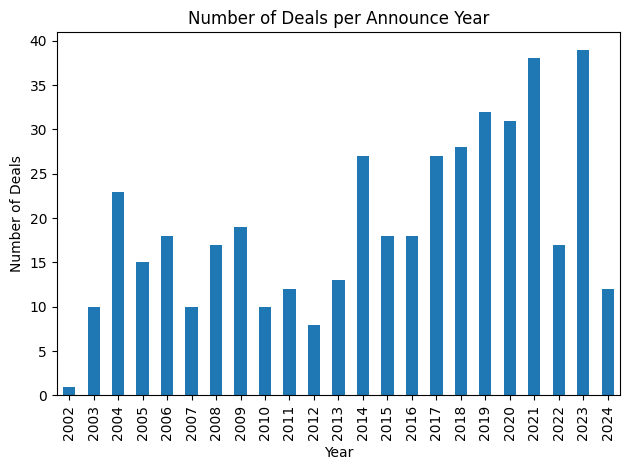

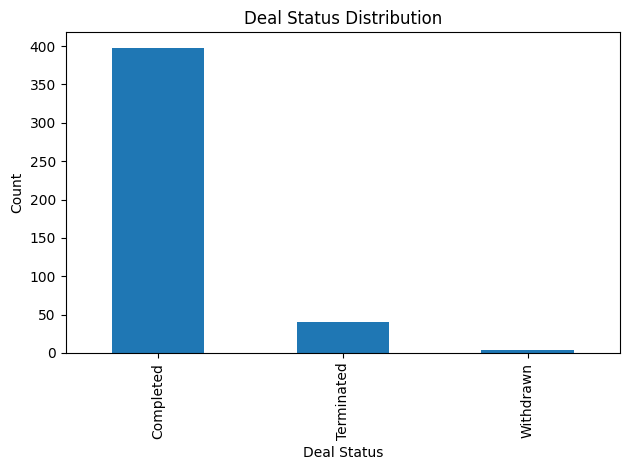

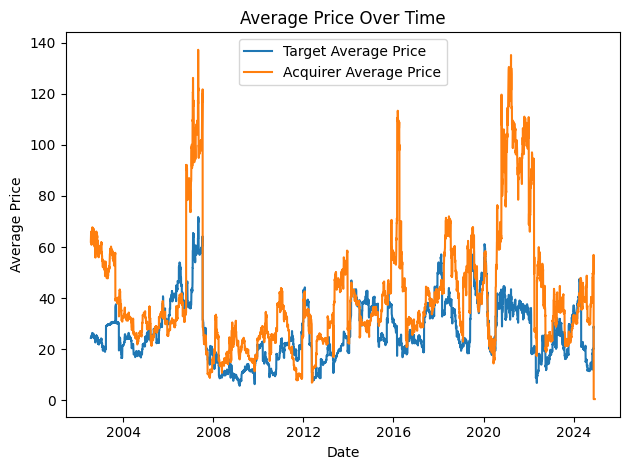

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# ----- Load the CSV files -----
deals_df = pd.read_csv('deals_stock.csv')
target_prices_df = pd.read_csv('Target_Prices.csv')
acquirer_prices_df = pd.read_csv('Acquirer_Prices.csv')

# ----- Visualizing Deals Data -----
# Convert 'Announce Date' to datetime and extract year
deals_df['Announce Date'] = pd.to_datetime(deals_df['Announce Date'])
deals_df['Announce Year'] = deals_df['Announce Date'].dt.year

# Plot number of deals per year
deals_per_year = deals_df['Announce Year'].value_counts().sort_index()

plt.figure()
deals_per_year.plot(kind='bar')
plt.title('Number of Deals per Announce Year')
plt.xlabel('Year')
plt.ylabel('Number of Deals')
plt.tight_layout()
plt.show()

# Plot deal status distribution (if the column 'Deal Status' exists)
if 'Deal Status' in deals_df.columns:
    status_counts = deals_df['Deal Status'].value_counts()
    plt.figure()
    status_counts.plot(kind='bar')
    plt.title('Deal Status Distribution')
    plt.xlabel('Deal Status')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# ----- Visualizing Price Data -----
# Convert date columns to datetime
target_prices_df['date'] = pd.to_datetime(target_prices_df['date'])
acquirer_prices_df['date'] = pd.to_datetime(acquirer_prices_df['date'])

# Compute the average price per date for targets and acquirers
target_mean = target_prices_df.groupby('date')['prc'].mean()
acquirer_mean = acquirer_prices_df.groupby('date')['prc'].mean()

# Plot the average price trends over time
plt.figure()
plt.plot(target_mean.index, target_mean.values, label='Target Average Price')
plt.plot(acquirer_mean.index, acquirer_mean.values, label='Acquirer Average Price')
plt.title('Average Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.tight_layout()
plt.show()
